<a href="https://colab.research.google.com/github/SrishtiCodeGit/AI-as-a-Systemic-Factor-in-Portfolio-Risk/blob/main/Measuring_and_Stress_Testing_Technology_Sector_Concentration_Risk_Using_Live_Market_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install yfinance

In [14]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
tickers={
     "AAPL": "Tech",
    "MSFT": "Tech",
    "NVDA": "Tech",
    "AMZN": "Tech",
    "GOOGL": "Tech",
    "META": "Tech",
    "JPM": "Finance",
    "UNH": "Healthcare",
    "XOM": "Energy"
}

In [43]:
data = []

for ticker, sector in tickers.items():
    stock = yf.Ticker(ticker)
    info = stock.info

    data.append({
        "Ticker": ticker,
        "Sector": sector,
        "MarketCap": info.get("marketCap", np.nan)
    })

df = pd.DataFrame(data)
df

,Ticker,Sector,MarketCap
0,AAPL,Tech,3888777003008
1,MSFT,Tech,2952363507712
2,NVDA,Tech,4621547864064
3,AMZN,Tech,2255514238976
4,GOOGL,Tech,3810313371648
5,META,Tech,1658528202752
6,JPM,Finance,846051934208
7,UNH,Healthcare,262693191680
8,XOM,Energy,621104136192


In [44]:
df = df.dropna() #risk model might fail with missing data, drop empty values
df["MarketCap"] = df["MarketCap"] / 1e12  # convert to trillions USD
df # now the market cap is in trillions

,Ticker,Sector,MarketCap
0,AAPL,Tech,3.888777
1,MSFT,Tech,2.952364
2,NVDA,Tech,4.621548
3,AMZN,Tech,2.255514
4,GOOGL,Tech,3.810313
5,META,Tech,1.658528
6,JPM,Finance,0.846052
7,UNH,Healthcare,0.262693
8,XOM,Energy,0.621104


In [45]:

total_market_cap = df["MarketCap"].sum()
df["Weight"] = df["MarketCap"] / total_market_cap
df

,Ticker,Sector,MarketCap,Weight
0,AAPL,Tech,3.888777,0.185916
1,MSFT,Tech,2.952364,0.141147
2,NVDA,Tech,4.621548,0.220948
3,AMZN,Tech,2.255514,0.107832
4,GOOGL,Tech,3.810313,0.182164
5,META,Tech,1.658528,0.079291
6,JPM,Finance,0.846052,0.040448
7,UNH,Healthcare,0.262693,0.012559
8,XOM,Energy,0.621104,0.029694


In [46]:
tech_weight = df[df["Sector"] == "Tech"]["Weight"].sum()

print("Technology sector concentration:", round(tech_weight * 100, 2), "%")

Technology sector concentration: 91.73 %


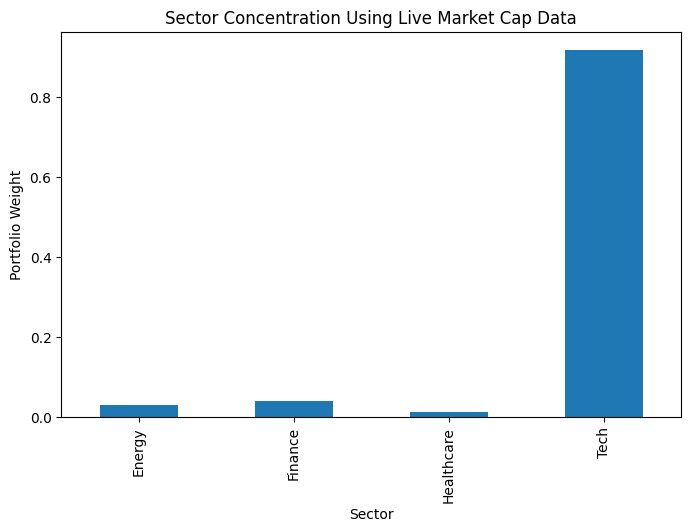

In [47]:
sector_weights = df.groupby("Sector")["Weight"].sum()

plt.figure(figsize=(8,5))
sector_weights.plot(kind="bar")
plt.title("Sector Concentration Using Live Market Cap Data")
plt.ylabel("Portfolio Weight")
plt.show()


In [48]:
shock = -0.25  # 25% tech drawdown (historically reasonable)

df["ShockReturn"] = 0.0
df.loc[df["Sector"] == "Tech", "ShockReturn"] = shock #ONLY for rows where Sector = Tech, replace 0 with -25%.

df["PortfolioImpact"] = df["Weight"] * df["ShockReturn"] #How much damage does each stock do to the portfolio?

portfolio_loss = df["PortfolioImpact"].sum() #This adds up all the damage.

print("Portfolio loss from 25% tech drawdown:",
      round(portfolio_loss * 100, 2), "%") #from decimals to percentages
df #show df

Portfolio loss from 25% tech drawdown: -22.93 %


,Ticker,Sector,MarketCap,Weight,ShockReturn,PortfolioImpact
0,AAPL,Tech,3.888777,0.185916,-0.25,-0.046479
1,MSFT,Tech,2.952364,0.141147,-0.25,-0.035287
2,NVDA,Tech,4.621548,0.220948,-0.25,-0.055237
3,AMZN,Tech,2.255514,0.107832,-0.25,-0.026958
4,GOOGL,Tech,3.810313,0.182164,-0.25,-0.045541
5,META,Tech,1.658528,0.079291,-0.25,-0.019823
6,JPM,Finance,0.846052,0.040448,0.00,0.000000
7,UNH,Healthcare,0.262693,0.012559,0.00,0.000000
8,XOM,Energy,0.621104,0.029694,0.00,0.000000




1.   Now this is what happens when its sector concentration risk

2.   But we were talking about the underlying tech risk be it in companies in diff sector like finance, healthcare or energy


---



***As everyone is advancing the the technolgy and dependent on it how do we consider that underlying risk :***

## **Diversification looks good but fails**
JPM -> AI in trading, compliance (AI underlying Risk)

UNH -> AI in diagnostics

XOM -> AI in optimization

META -> AI core business

A low-frequency, high-impact systemic AI/technology shock that increases correlation across sectors

Lets Introduce Latent factor.
Which is unerlying factor not a risk
We will introduce a continuous exposure score, not a label.

AI Exposure Score will be betweeen 0 and 1
Instead of Sock factor
we will consider AI factor experience


In [54]:
ai_exposure_map = {
    "AAPL": 0.70,
    "MSFT": 0.90,
    "NVDA": 0.95,
    "AMZN": 0.75,
    "GOOGL": 0.90,
    "META": 0.85,
    "JPM": 0.55,
    "UNH": 0.50,
    "XOM": 0.30
}

df["AI_Exposure"] = df["Company"].map(ai_exposure_map)

df["AI_Weighted_Exposure"] = df["Weight"] * df["AI_Exposure"]

portfolio_ai_exposure = df["AI_Weighted_Exposure"].sum()

portfolio_ai_exposure


np.float64(0.8164999999999999)

Although the portfolio appears diversified by sector, over 80% of its risk is effectively exposed to a common AI factor, meaning a negative AI shock could cause cross-sector drawdowns.

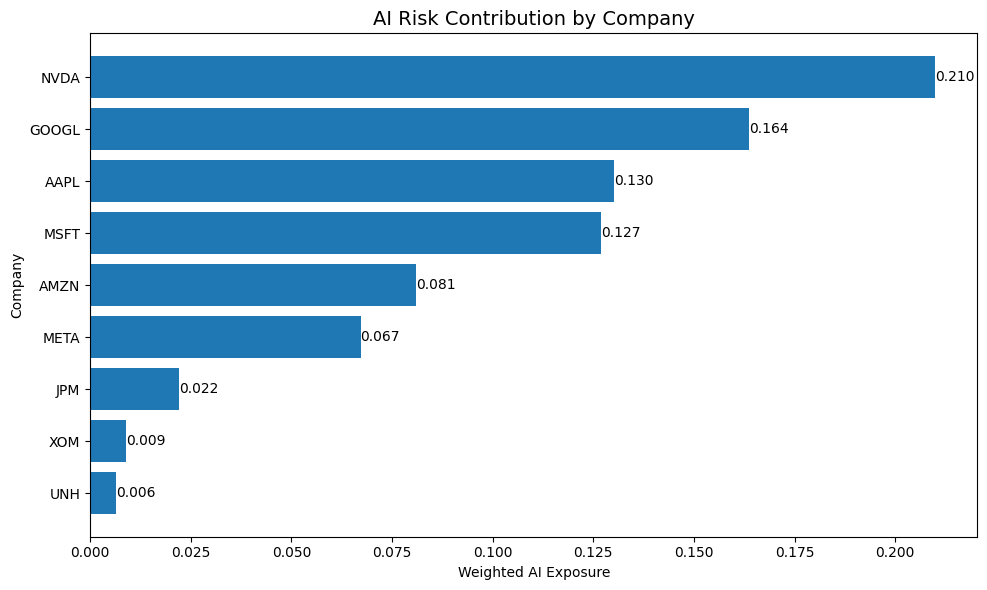

In [69]:
import matplotlib.pyplot as plt

df_plot = df.sort_values("AI_Weighted_Exposure", ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    df_plot["Company"],
    df_plot["AI_Weighted_Exposure"]
)

plt.title("AI Risk Contribution by Company", fontsize=14)
plt.xlabel("Weighted AI Exposure")
plt.ylabel("Company")

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va="center",
        ha="left"
    )

plt.tight_layout()
plt.show()

** Stress Test: What is AI breaks tomorrow **

Companies with higher AI exposure fall more

Loss is not uniform
# Shock Impact(i) ​= AI Exposure(i) * Shock Severity

In [57]:
ai_shock = -0.20 #lets say AI shock impact is -20% for a business dependent on AI

In [59]:
df["AI_Shock_Return"] = df["AI_Exposure"] * ai_shock #what will be the company level impact based on their AI dependency
df["AI_Exposure"]

,AI_Exposure
0,0.70
1,0.90
2,0.95
3,0.75
4,0.90
5,0.85
6,0.55
7,0.50
8,0.30


In [60]:
df["Weighted_Shock_Impact"] = df["Weight"] * df["AI_Shock_Return"] #portfolio impact

portfolio_shock_loss = df["Weighted_Shock_Impact"].sum()

portfolio_shock_loss

np.float64(-0.1633)

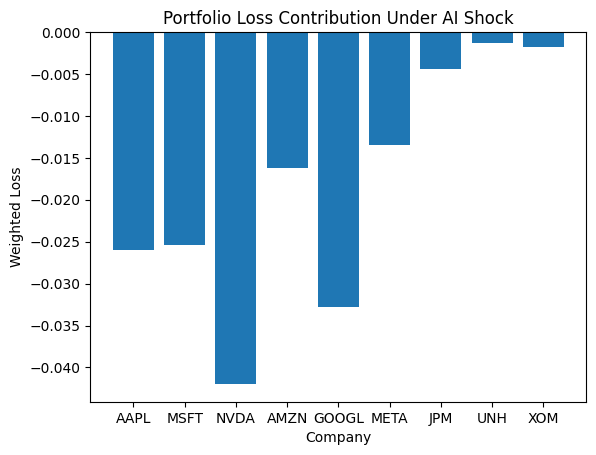

In [62]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df["Company"], df["Weighted_Shock_Impact"])
plt.title("Portfolio Loss Contribution Under AI Shock")
plt.xlabel("Company")
plt.ylabel("Weighted Loss")
plt.show()

correlation

In [63]:
normal_corr = 0.30

In [64]:
ai_crisis_corr = 0.85

In [65]:
normal_risk = normal_corr * portfolio_ai_exposure
crisis_risk = ai_crisis_corr * portfolio_ai_exposure

risk_multiplier = crisis_risk / normal_risk #Portfolio variance intuition

risk_multiplier

np.float64(2.8333333333333335)

Under an AI-driven systemic event, portfolio risk increases nearly 3× due to correlation convergence, even though the portfolio is diversified by sector.

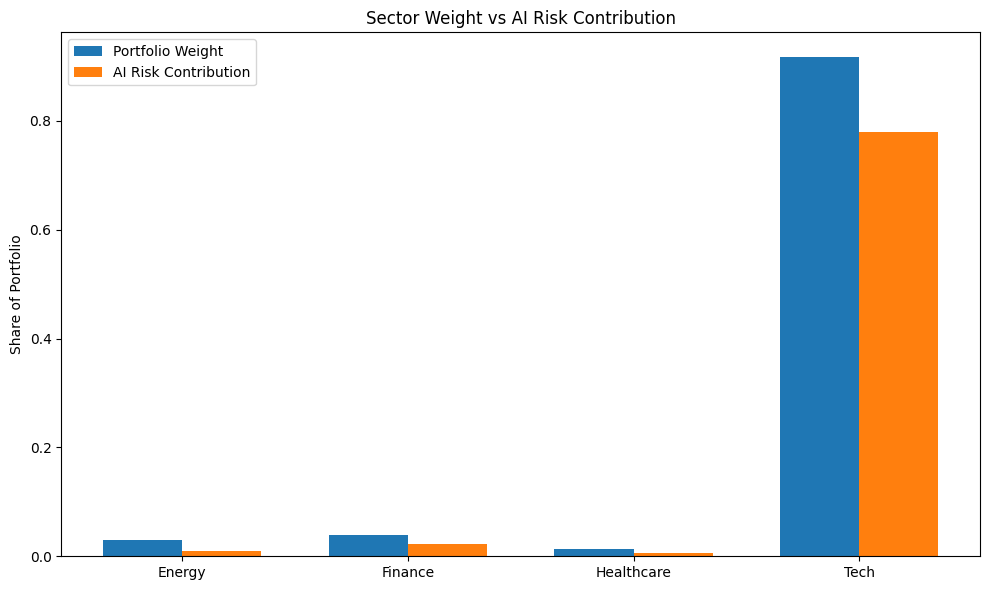

In [72]:
import numpy as np

x = np.arange(len(sector_ai))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, sector_ai["Weight"], width, label="Portfolio Weight")
plt.bar(x + width/2, sector_ai["AI_Weighted_Exposure"], width, label="AI Risk Contribution")

plt.xticks(x, sector_ai["Sector"])
plt.ylabel("Share of Portfolio")
plt.title("Sector Weight vs AI Risk Contribution")
plt.legend()

plt.tight_layout()
plt.show()

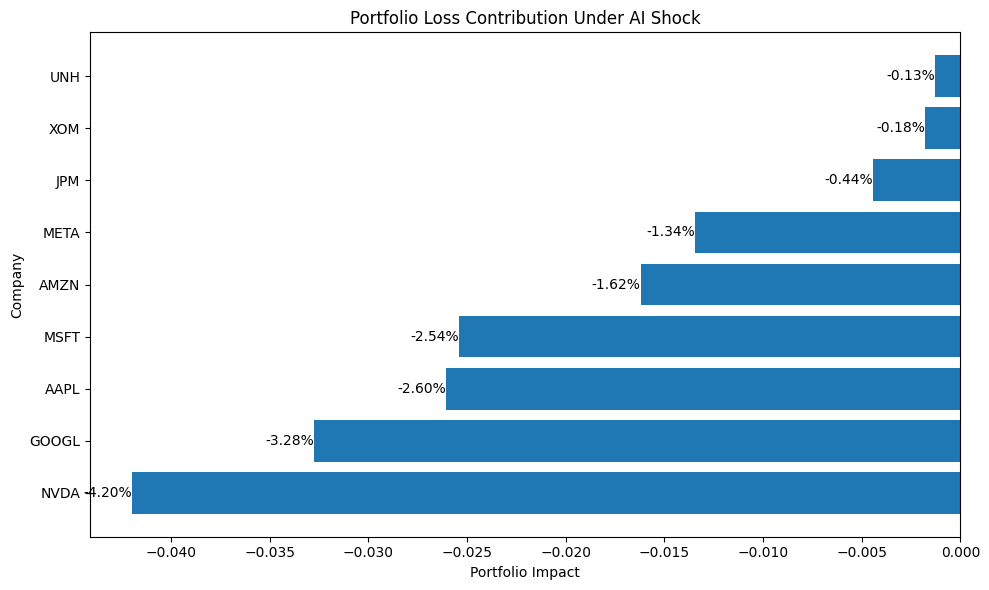

In [74]:
df_shock = df.sort_values("Weighted_Shock_Impact")

plt.figure(figsize=(10, 6))
bars = plt.barh(
    df_shock["Company"],
    df_shock["Weighted_Shock_Impact"]
)

plt.title("Portfolio Loss Contribution Under AI Shock")
plt.xlabel("Portfolio Impact")
plt.ylabel("Company")

for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2%}",
        va="center",
        ha="right"
    )

plt.tight_layout()
plt.show()

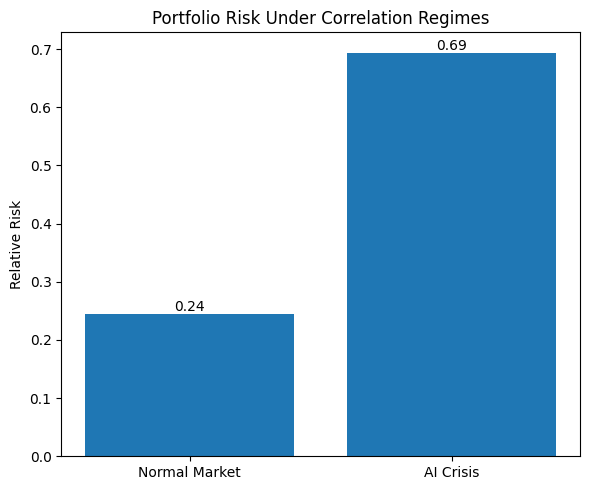

In [75]:
plt.figure(figsize=(6, 5))

plt.bar(
    ["Normal Market", "AI Crisis"],
    [normal_risk, crisis_risk]
)

plt.title("Portfolio Risk Under Correlation Regimes")
plt.ylabel("Relative Risk")

for i, v in enumerate([normal_risk, crisis_risk]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()